# Artificial Neural Networks and Deep Learning

---

## Homework 1: Minimal Working Example

To make your first submission, follow these steps:
1. Create a folder named `[2024-2025] AN2DL/Homework 1` in your Google Drive.
2. Upload the `training_set.npz` file to this folder.
3. Upload the Jupyter notebook `Homework 1 - Minimal Working Example.ipynb`.
4. Load and process the data.
5. Implement and train your model.
6. Submit the generated `.zip` file to Codabench.

## 🌐 Connect Colab to Google Drive

In [1]:
from google.colab import drive

drive.mount('/gdrive')
%cd /gdrive/My Drive/[2024-2025]AN2DL/

Mounted at /gdrive
/gdrive/.shortcut-targets-by-id/13hqtEnMZc15GLH-6dl_fjgf_U0alzShx/[2024-2025]AN2DL


## ⚙️ Import Libraries

In [2]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os
import json

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)


import tensorflow as tf
#from tensorflow import keras as tfk
import keras as tfk       #notice how I'm importing keras and not tensorflow.keras
from keras.layers import Input, Dense, Dropout, Lambda
#from tensorflow.keras.layers import Input, Dense, Dropout, Lambda
from keras import layers as tfkl


print(f"Tensorflow version -> {tf.__version__}")
print(f"Keras version -> {tfk.__version__}")
# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import requests
from io import BytesIO
import cv2
from PIL import Image
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

Tensorflow version -> 2.17.1
Keras version -> 3.5.0
2.17.1


## ⏳ Load the Data

In [5]:
def load_processed_data(folder_path="processed_dataCutAugMix"):
    """
    Loads processed training and validation datasets from a specified folder.

    Parameters:
        folder_path (str): Folder path from which to load the data.

    Returns:
        X_train, y_train, X_val, y_val (numpy arrays): Loaded datasets.
    """
    # Load the datasets
    X_train = np.load(os.path.join(folder_path, "X_train.npy"))
    y_train = np.load(os.path.join(folder_path, "y_train.npy"))
    X_val = np.load(os.path.join(folder_path, "X_val.npy"))
    y_val = np.load(os.path.join(folder_path, "y_val.npy"))

    print(f"Processed data loaded from folder: {folder_path}")
    return X_train, y_train, X_val, y_val


In [6]:
X_train, y_train, X_val, y_val = load_processed_data()

print("Training Data Shape:", X_train.shape)
print("Training Label Shape:", y_train.shape)
print("Validation Data Shape:", X_val.shape)
print("Validation Label Shape:", y_val.shape)


Processed data loaded from folder: processed_dataNOBack
Training Data Shape: (14200, 96, 96, 3)
Training Label Shape: (14200,)
Validation Data Shape: (1196, 96, 96, 3)
Validation Label Shape: (1196, 1)


In [7]:
# Define a mapping of labels to their corresponding cell type names
labels = {
    0: 'Basophil',
    1: 'Eosinophil',
    2: 'Erythroblast',
    3: 'Immature granulocytes',
    4: 'Lymphocyte',
    5: 'Monocyte',
    6: 'Neutrophil',
    7: 'Platelet'
}
# Save unique labels
unique_labels = list(labels.values())

## 🔄 Process Data

In [8]:
import numpy as np
from sklearn.utils import class_weight

# Calcola i pesi delle classi
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train.flatten()), y=y_train.flatten())
class_weight_dict = dict(enumerate(class_weights))

print("Class weights:", class_weight_dict)




Class weights: {0: 1.3738390092879258, 1: 0.7871396895787139, 2: 1.0764099454214675, 3: 0.8480649784997611, 4: 1.3749031758326877, 5: 1.1762756792577866, 6: 0.7362090418913314, 7: 1.0441176470588236}


In [9]:

# Convert class labels to categorical format for training, validation, and test sets
y_train = tfk.utils.to_categorical(y_train, num_classes=len(unique_labels))
y_val = tfk.utils.to_categorical(y_val, num_classes=len(unique_labels))



# Print shapes of the datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")

X_train shape: (14200, 96, 96, 3), y_train shape: (14200, 8)
X_val shape: (1196, 96, 96, 3), y_val shape: (1196, 8)


In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Create an instance of ImageDataGenerator with Data Augmentation
aug_train_data_gen = ImageDataGenerator(rotation_range=20,
                                        horizontal_flip=True,
                                        vertical_flip=True,
                                        brightness_range=(0.6, 1.4),
                                        zoom_range=0.6,
                                        fill_mode='nearest')


aug_train_gen = aug_train_data_gen.flow(
    x=X_train,          # Input images
    y=y_train,          # Labels
    batch_size=32,      # Batch size
    shuffle=True,       # Shuffle the data
    seed=seed           # Reproducibility
  )


In [11]:
valid_data_gen = ImageDataGenerator()

# Creazione del generatore senza preprocessing
valid_gen = valid_data_gen.flow(
    x=X_val,
    y=y_val,
    batch_size=32,
    shuffle=True,
    seed=seed
)

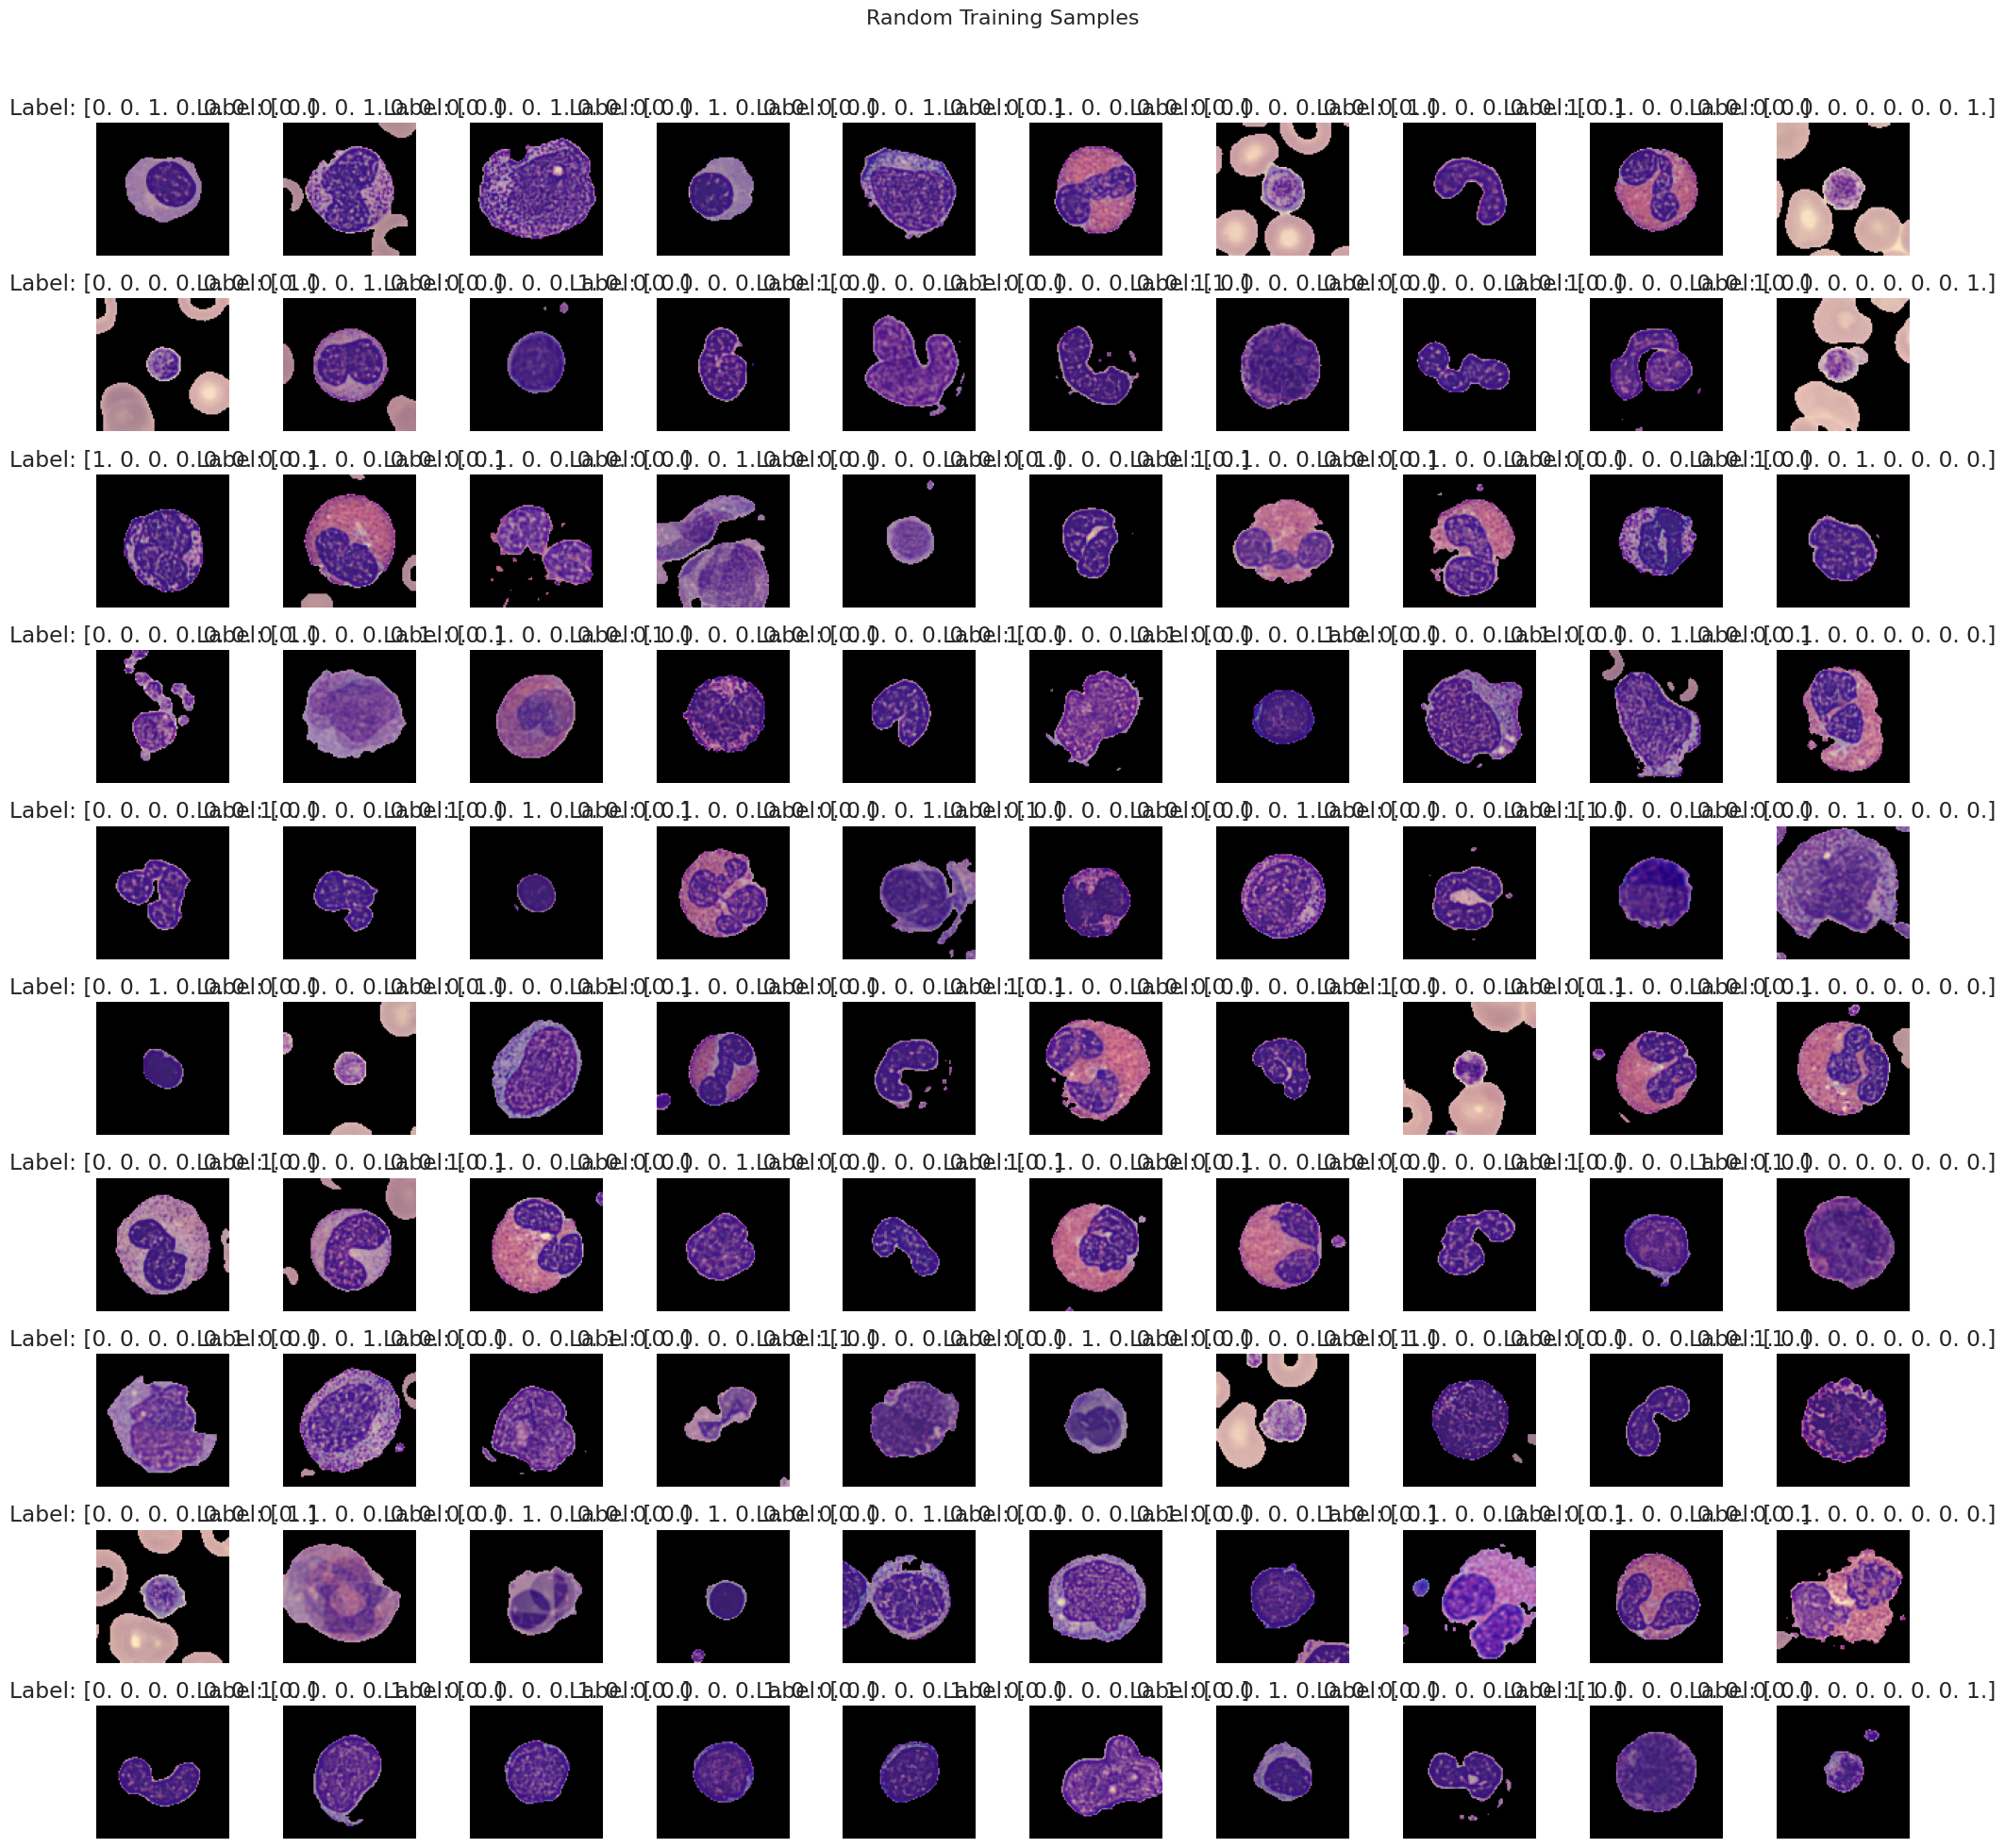

In [13]:
import matplotlib.pyplot as plt
import numpy as np

def display_random_samples(X, y, grid_size=(10, 10), title="Random Samples"):
    """
    Displays random samples from the dataset in a grid.

    Parameters:
        X (numpy array): Array of images (num_samples, height, width, channels).
        y (numpy array): Corresponding labels (num_samples,).
        grid_size (tuple): Grid dimensions (rows, cols). Default is (10, 10).
        title (str): Title for the entire grid.
    """
    rows, cols = grid_size
    num_samples = rows * cols

    # Randomly select indices for the samples
    random_indices = np.random.choice(X.shape[0], num_samples, replace=False)
    selected_images = X[random_indices]
    selected_labels = y[random_indices]

    # Create the plot
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    fig.suptitle(title, fontsize=16)

    for i, ax in enumerate(axes.flat):
        # Display the image
        ax.imshow(selected_images[i].astype('uint8'))
        ax.set_title(f"Label: {selected_labels[i]}")
        ax.axis("off")

    plt.tight_layout()
    plt.subplots_adjust(top=0.92)  # Adjust space for the title
    plt.show()

# Example usage
# Assuming X_train and y_train are NumPy arrays
# X_train: (num_samples, height, width, channels)
# y_train: (num_samples,)
display_random_samples(X_train, y_train, grid_size=(10, 10), title="Random Training Samples")


## 🧮 Define Network Parameters

In [14]:
# Input shape for the model
input_shape = X_train.shape[1:]

# Output shape for the model
output_shape = y_train.shape[-1]

print("Input Shape:", input_shape)
print("Output Shape:", output_shape)

Input Shape: (96, 96, 3)
Output Shape: 8


In [16]:
# Number of training epochs
epochs = 500

# Batch size for training
batch_size = 32

# Learning rate: step size for updating the model's weights
learning_rate = 0.001


l2_lambda = 1e-4

# Augmentation: set an augmentation layer or not
augmentation = True

# Patience
patience = 7

folder_name = "ResNet_SaraNoBack"

# Dropout

#Name
name = 'ResNet50_aug'

#Display the architecture
display = False

# Print the defined parameters
print("Epochs:", epochs)
print("Batch Size:", batch_size)
print("Learning Rate:", learning_rate)
print("Augmentation:", augmentation)
print("Patience:", patience)

Epochs: 500
Batch Size: 32
Learning Rate: 0.001
Augmentation: True
Patience: 7


In [17]:
def save_model(code, model, history, folder_name):

    """

    Salva il modello e i parametri in una cartella specificata.



    Args:

    - model: il modello da salvare

    - params: dizionario contenente i parametri da salvare (es. learning rate, batch size, etc.)

    - folder_name: nome della cartella di destinazione (default: 'model_folder')

    """

    # Crea la cartella se non esiste

    os.makedirs(folder_name, exist_ok=True)



    if code == 0:

          model_save_path = os.path.join(folder_name, 'weightsTL.keras')

          model.save(model_save_path)

          print(f"ModelTL saved at: {model_save_path}")

    else:

         model_save_path = os.path.join(folder_name, 'weights.keras')

         model.save(model_save_path)

         print(f"Model saved at: {model_save_path}")



    # Salvataggio della history in un file JSON

    if code == 0:

       history_save_path = os.path.join(folder_name, 'historyTL.json')

       with open(history_save_path, 'w') as f:

           json.dump(history, f, indent=4)

       print(f"HistoryTL saved at: {history_save_path}")

    else:

      history_save_path = os.path.join(folder_name, 'history.json')

      with open(history_save_path, 'w') as f:

           json.dump(history, f, indent=4)

      print(f"History saved at: {history_save_path}")

## 🛠️ buid the model

In [18]:
# Initialize ResNet50 model with pretrained weights for transfer learning
tl_model = tfk.applications.ResNet50(
    input_shape=input_shape,
    include_top=False,
    weights='imagenet',
    pooling='avg',
)


# Display a summary of the model architecture
if display:
   tl_model.summary(expand_nested=True)

# Display the architecture with layer shapes and trainable parameters
if display:
   tfk.utils.plot_model(tl_model, expand_nested=False, show_trainable=True, show_shapes=False, dpi=70)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [19]:
# Initialise weights and regulariser
initialiser = tfk.initializers.GlorotNormal(seed=seed)
regulariser = tfk.regularizers.l2(l2_lambda)


tl_model.trainable = False

# Define input layer with shape matching the input images

# inputs = tfk.Input(shape=input_shape, name='input_layer')

inputs = tfk.Input(shape=(None, None, 3), name='input_layer')  # Accept any input size
x_in = tfkl.Resizing(96, 96)(inputs)  # Resize images to 96x96


# Apply data augmentation for training robustness

augmentation = tf.keras.Sequential([

    # Geometric transformations
    tfkl.RandomFlip("horizontal"),                         # Flipping orizzontale casuale
    tfkl.RandomFlip("vertical"),
    tfkl.RandomTranslation(0.2, 0.2),                      # Traslazione casuale fino al 20% dell'altezza e larghezza
    tfkl.RandomRotation(0.5),                              # Rotazione casuale fino a ±0.5 radianti (~28.6 gradi)
    tfkl.RandomZoom(0.2),                                  # Zoom casuale fino al 20%

    # Color adjustments
    tfkl.RandomBrightness(0.2),                            # Aggiustamento casuale della luminosità ±20%
    tfkl.RandomContrast(0.2),                              # Aggiustamento casuale del contrasto ±20%

    # Noise injection
    tfkl.GaussianNoise(0.1),                               # Aggiunge rumore gaussiano con deviazione standard 0.1

   ], name='preprocessing')

# Applica l'augmentation ai dati di input
x = augmentation(x_in)



if augmentation:
    x = tl_model(x)
else:
    x = tl_model(x_in)


x = tfkl.Dense(256, activation='relu',kernel_initializer=initialiser,kernel_regularizer=regulariser, name='dense_1')(x)
x = tfkl.Dropout(0.3, name='dropout')(x)
x = tfkl.Dense(128, activation='relu',kernel_initializer=initialiser,kernel_regularizer=regulariser, name='dense_2')(x)


# Add final Dense layer for classification with softmax activation
outputs = tfkl.Dense(output_shape, activation='softmax', name='dense')(x)

# Define the complete model linking input and output
tl_model = tfk.Model(inputs=inputs, outputs=outputs, name=name)


#Implementiamo Learning Rate decay

initial_learning_rate = learning_rate
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=8000,
    decay_rate=0.96,
    staircase=True
)

# Compile the model with categorical cross-entropy loss and Adam optimiser
tl_model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.AdamW(learning_rate=lr_schedule, weight_decay=l2_lambda),
    metrics=['accuracy']
)
# Display a summary of the model architecture
if display:
   tl_model.summary(expand_nested=True)

# Display model architecture with layer shapes and trainable parameters
if display:
   tfk.utils.plot_model(tl_model, expand_nested=False, show_trainable=False, show_shapes=True, dpi=70)

## 🧠 Train and save the Model

In [20]:
from tensorflow.keras import mixed_precision
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import Callback

# Imposta la policy mixed float16
mixed_precision.set_global_policy('mixed_float16')

# Define the patience value for early stopping
patience = patience

# Create an EarlyStopping callback
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=patience,
    restore_best_weights=True
)

# Store the callback in a list
callbacks = [early_stopping]

In [21]:

# Train the model
tl_history_obj = tl_model.fit(
    x=aug_train_gen,
    batch_size= batch_size,
    epochs= epochs,
    validation_data=valid_gen,
    callbacks= callbacks,
    class_weight=class_weight_dict
)
tl_history= tl_history_obj.history

# Calculate and print the best validation accuracy achieved
final_val_accuracy = round(max(tl_history_obj.history['val_accuracy']) * 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file, including final accuracy in the filename
save_model(0,tl_model, tl_history, folder_name)  #+ str(final_val_accuracy)

# Free memory by deleting the model instance
del tl_model

Epoch 1/500
444/444 ━━━━━━━━━━━━━━━━━━━━ 74s 134ms/step - accuracy: 0.5014 - loss: 1.5131 - val_accuracy: 0.5318 - val_loss: 1.2569
Epoch 2/500
444/444 ━━━━━━━━━━━━━━━━━━━━ 55s 122ms/step - accuracy: 0.6518 - loss: 1.0419 - val_accuracy: 0.6396 - val_loss: 1.0396
Epoch 3/500
444/444 ━━━━━━━━━━━━━━━━━━━━ 80s 118ms/step - accuracy: 0.6827 - loss: 0.9556 - val_accuracy: 0.5184 - val_loss: 1.5568
Epoch 4/500
444/444 ━━━━━━━━━━━━━━━━━━━━ 82s 119ms/step - accuracy: 0.7050 - loss: 0.9075 - val_accuracy: 0.5945 - val_loss: 1.2511
Epoch 5/500
444/444 ━━━━━━━━━━━━━━━━━━━━ 53s 119ms/step - accuracy: 0.7059 - loss: 0.8863 - val_accuracy: 0.5953 - val_loss: 1.2276
Epoch 6/500
444/444 ━━━━━━━━━━━━━━━━━━━━ 56s 124ms/step - accuracy: 0.7063 - loss: 0.8711 - val_accuracy: 0.7124 - val_loss: 0.8547
Epoch 7/500
444/444 ━━━━━━━━━━━━━━━━━━━━ 81s 123ms/step - accuracy: 0.7188 - loss: 0.8556 - val_accuracy: 0.6229 - val_loss: 1.1211
Epoch 8/500
444/444 ━━━━━━━━━━━━━━━━━━━━ 80s 119ms/step - accuracy: 0.7286 -

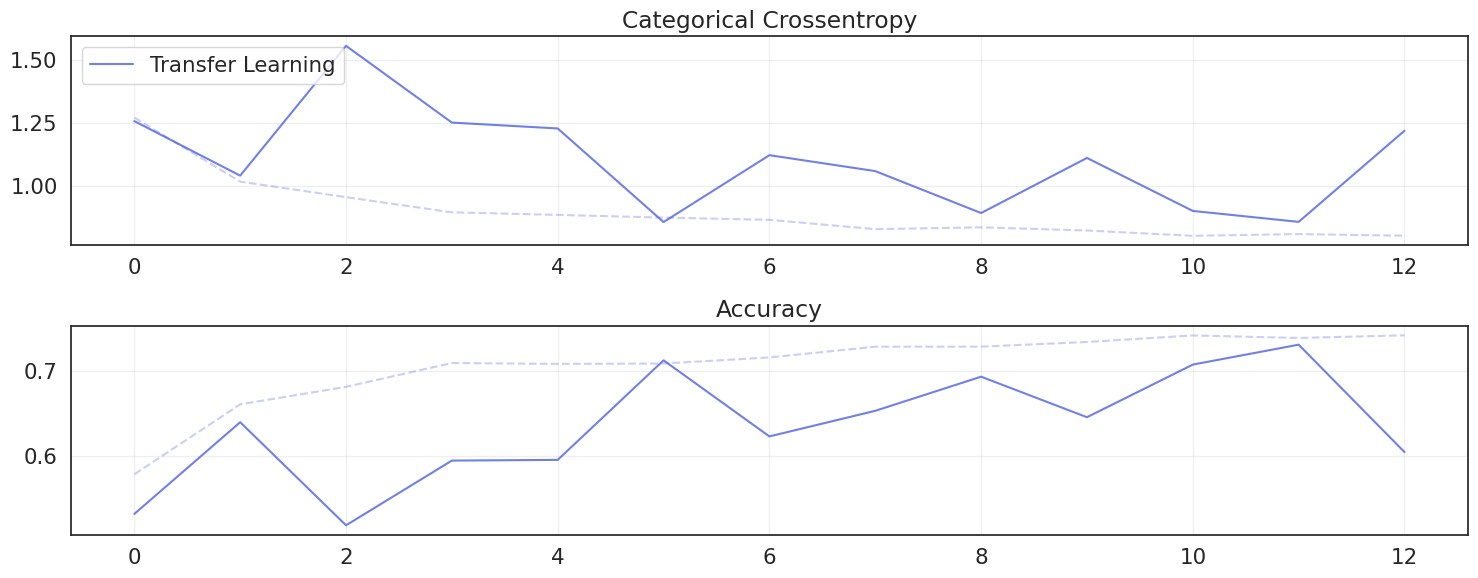

In [22]:
# Create figure and subplots for loss and accuracy
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 6))

# Plot loss for both re-trained and transfer learning models

ax1.plot(tl_history['loss'], alpha=0.3, color='#4D61E2', linestyle='--')
ax1.plot(tl_history['val_loss'], label='Transfer Learning', alpha=0.8, color='#4D61E2')
ax1.set_title('Categorical Crossentropy')
ax1.legend(loc='upper left')
ax1.grid(alpha=0.3)

# Plot accuracy for both re-trained and transfer learning models

ax2.plot(tl_history['accuracy'], alpha=0.3, color='#4D61E2', linestyle='--')
ax2.plot(tl_history['val_accuracy'], label='Transfer Learning', alpha=0.8, color='#4D61E2')
ax2.set_title('Accuracy')
ax2.grid(alpha=0.3)

# Adjust layout to prevent label overlap and display the plots
plt.tight_layout()
plt.show()

## :) FINE TUNING

In [23]:
ft_model = tfk.models.load_model(folder_name+'/weightsTL.keras')
# Display a summary of the model architecture
ft_model.summary(expand_nested=True,show_trainable=True)

# Display model architecture with layer shapes and trainable parameters
#tfk.utils.plot_model(ft_model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

Model: "ResNet50_aug"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                 ┃       Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer (InputLayer)            │ (None, None, None, 3)        │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ resizing (Resizing)                 │ (None, 96, 96, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ preprocessing (Sequential)          │ (None, 96, 96, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ random_flip (RandomFlip)       │ (None, 96, 96, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ random_flip_1 (RandomFlip)     │ (None, 96, 96, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ random_translation             │ (None, 96, 96, 3)            │             0 │    -    │
│ (RandomTranslation)                 │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ random_rotation                │ (None, 96, 96, 3)            │             0 │    -    │
│ (RandomRotation)                    │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ random_zoom (RandomZoom)       │ (None, 96, 96, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ random_brightness              │ (None, 96, 96, 3)            │             0 │    -    │
│ (RandomBrightness)                  │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ random_contrast                │ (None, 96, 96, 3)            │             0 │    -    │
│ (RandomContrast)                    │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ gaussian_noise (GaussianNoise) │ (None, 96, 96, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ resnet50 (Functional)               │ (None, 2048)                 │    23,587,712 │    N    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ input_layer (InputLayer)       │ (None, 96, 96, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ conv1_pad (ZeroPadding2D)      │ (None, 102, 102, 3)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ conv1_conv (Conv2D)            │ (None, 48, 48, 64)           │         9,472 │    N    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ conv1_bn (BatchNormalization)  │ (None, 48, 48, 64)           │           256 │    N    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ conv1_relu (Activation)        │ (None, 48, 48, 64)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ pool1_pad (ZeroP

 Total params: 25,263,133 (96.37 MB)

 Trainable params: 558,472 (2.13 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

 Optimizer params: 1,116,949 (4.26 MB)

In [24]:
ft_model.get_layer('resnet50').trainable = True

# Set all ResNet50 layers as non-trainable initially
for layer in ft_model.get_layer('resnet50').layers:
    layer.trainable = False

# Enable training for only the last 20 convolutional layers
conv_layers = [layer for layer in ft_model.get_layer('resnet50').layers if isinstance(layer, tf.keras.layers.Conv2D)]

# Unfreeze the last 20 convolutional layers
for layer in conv_layers[-10:]:
    layer.trainable = True
    print(layer.name, type(layer).__name__, layer.trainable)

conv5_block1_1_conv Conv2D True
conv5_block1_2_conv Conv2D True
conv5_block1_0_conv Conv2D True
conv5_block1_3_conv Conv2D True
conv5_block2_1_conv Conv2D True
conv5_block2_2_conv Conv2D True
conv5_block2_3_conv Conv2D True
conv5_block3_1_conv Conv2D True
conv5_block3_2_conv Conv2D True
conv5_block3_3_conv Conv2D True


In [25]:


initial_learning_rate = learning_rate/5
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=8000,
    decay_rate=0.96,
    staircase=True
)

optimizer = tf.keras.optimizers.AdamW(learning_rate=lr_schedule, weight_decay=l2_lambda)

ft_model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=optimizer,
    metrics=['accuracy']
)




In [26]:
# Fine-tune the model
ft_history_obj = ft_model.fit(
    x = X_train,  # Ensure images are scaled from [0,1] to [0,255]
    y = y_train,
    batch_size = 32,
    epochs = 100,
    validation_data=(X_val, y_val),
    callbacks= callbacks,
    class_weight=class_weight_dict
)
ft_history = ft_history_obj.history

# Calculate and print the final validation accuracy
final_val_accuracy = round(max(ft_history['val_accuracy']) * 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file, including final accuracy in the filename
save_model(1,ft_model, ft_history, folder_name)

# Delete the model to free up resources
del ft_model

Epoch 1/100
444/444 ━━━━━━━━━━━━━━━━━━━━ 45s 74ms/step - accuracy: 0.7368 - loss: 0.8225 - val_accuracy: 0.7291 - val_loss: 0.7812
Epoch 2/100
444/444 ━━━━━━━━━━━━━━━━━━━━ 35s 64ms/step - accuracy: 0.8389 - loss: 0.5063 - val_accuracy: 0.7784 - val_loss: 0.7200
Epoch 3/100
444/444 ━━━━━━━━━━━━━━━━━━━━ 41s 64ms/step - accuracy: 0.8545 - loss: 0.4534 - val_accuracy: 0.8211 - val_loss: 0.5829
Epoch 4/100
444/444 ━━━━━━━━━━━━━━━━━━━━ 41s 64ms/step - accuracy: 0.8662 - loss: 0.4168 - val_accuracy: 0.8378 - val_loss: 0.4957
Epoch 5/100
444/444 ━━━━━━━━━━━━━━━━━━━━ 41s 64ms/step - accuracy: 0.8741 - loss: 0.3933 - val_accuracy: 0.8562 - val_loss: 0.4261
Epoch 6/100
444/444 ━━━━━━━━━━━━━━━━━━━━ 41s 64ms/step - accuracy: 0.8833 - loss: 0.3734 - val_accuracy: 0.8712 - val_loss: 0.4165
Epoch 7/100
444/444 ━━━━━━━━━━━━━━━━━━━━ 41s 64ms/step - accuracy: 0.8823 - loss: 0.3689 - val_accuracy: 0.8779 - val_loss: 0.3762
Epoch 8/100
444/444 ━━━━━━━━━━━━━━━━━━━━ 28s 64ms/step - accuracy: 0.8801 - loss: 0

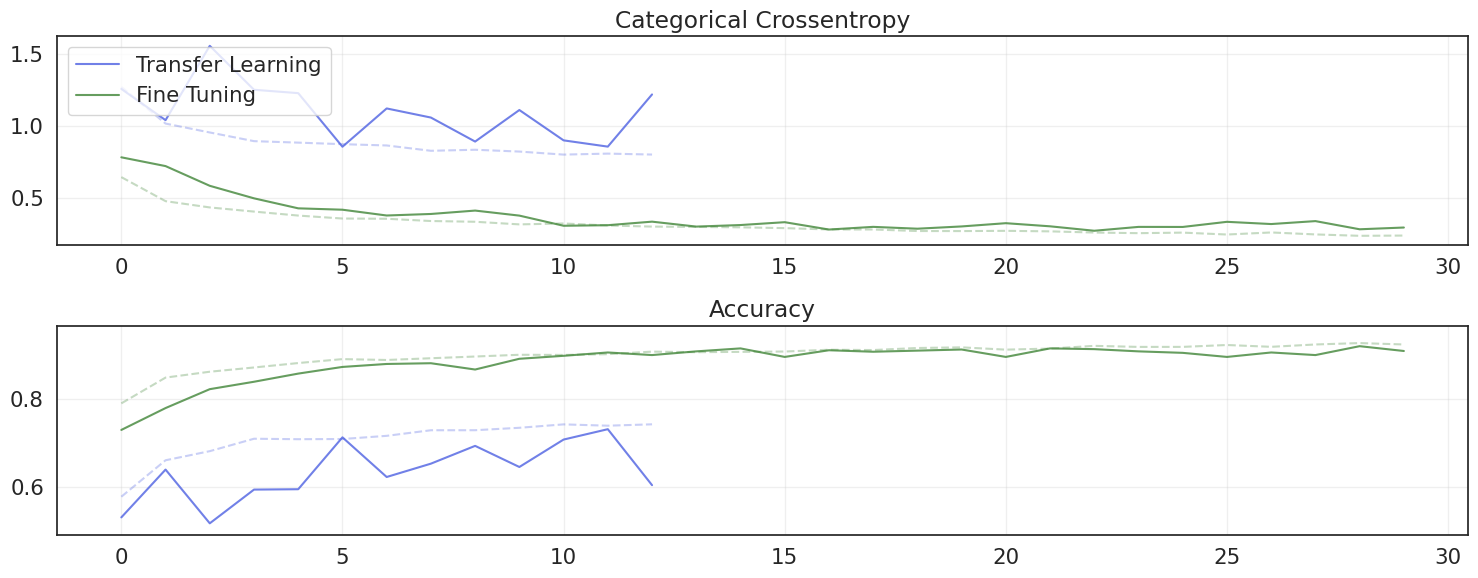

In [27]:
# Create figure and subplots for loss and accuracy
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 6))

# Plot categorical cross-entropy loss for both Transfer Learning and Fine Tuning stages
ax1.plot(tl_history['loss'], alpha=0.3, color='#4D61E2', linestyle='--')
ax1.plot(tl_history['val_loss'], label='Transfer Learning', alpha=0.8, color='#4D61E2')
ax1.plot(ft_history['loss'], alpha=0.3, color='#408537', linestyle='--')
ax1.plot(ft_history['val_loss'], label='Fine Tuning', alpha=0.8, color='#408537')
ax1.set_title('Categorical Crossentropy')
ax1.legend(loc='upper left')
ax1.grid(alpha=0.3)

# Plot accuracy for both Transfer Learning and Fine Tuning stages
ax2.plot(tl_history['accuracy'], alpha=0.3, color='#4D61E2', linestyle='--')
ax2.plot(tl_history['val_accuracy'], label='Transfer Learning', alpha=0.8, color='#4D61E2')
ax2.plot(ft_history['accuracy'], alpha=0.3, color='#408537', linestyle='--')
ax2.plot(ft_history['val_accuracy'], label='Fine Tuning', alpha=0.8, color='#408537')
ax2.set_title('Accuracy')
ax2.set_ylim([min(tl_history['val_accuracy']) * 0.95, max(ft_history['val_accuracy']) * 1.05])
ax2.grid(alpha=0.3)

# Adjust layout to prevent overlap and display the plots
plt.tight_layout()
plt.show()

In [29]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


In [ ]:
print("TRANFER LEARNING ANALYSIS")
model = tfk.models.load_model(folder_name+'/weightsTL.keras')

# Predict class probabilities and get predicted classes
train_predictions = model.predict(X_train, verbose=0)
train_predictions = np.argmax(train_predictions, axis=-1)

# Extract ground truth classes
train_gt = np.argmax(y_train, axis=-1)

# Calculate and display training set accuracy
train_accuracy = accuracy_score(train_gt, train_predictions)
print(f'Accuracy score over the train set: {round(train_accuracy, 4)}')

# Calculate and display training set precision
train_precision = precision_score(train_gt, train_predictions, average='weighted')
print(f'Precision score over the train set: {round(train_precision, 4)}')

# Calculate and display training set recall
train_recall = recall_score(train_gt, train_predictions, average='weighted')
print(f'Recall score over the train set: {round(train_recall, 4)}')

# Calculate and display training set F1 score
train_f1 = f1_score(train_gt, train_predictions, average='weighted')
print(f'F1 score over the train set: {round(train_f1, 4)}')

# Compute the confusion matrix
cm = confusion_matrix(train_gt, train_predictions)

# Create labels combining confusion matrix values
labels = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Plot the confusion matrix with class labels
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=labels, fmt='', xticklabels= unique_labels, yticklabels= unique_labels, cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

print("FINE TUNING ANALYSIS")
model = tfk.models.load_model(folder_name+'/weights.keras')

# Predict class probabilities and get predicted classes
train_predictions = model.predict(X_train, verbose=0)
train_predictions = np.argmax(train_predictions, axis=-1)

# Extract ground truth classes
train_gt = np.argmax(y_train, axis=-1)

# Calculate and display training set accuracy
train_accuracy = accuracy_score(train_gt, train_predictions)
print(f'Accuracy score over the train set: {round(train_accuracy, 4)}')

# Calculate and display training set precision
train_precision = precision_score(train_gt, train_predictions, average='weighted')
print(f'Precision score over the train set: {round(train_precision, 4)}')

# Calculate and display training set recall
train_recall = recall_score(train_gt, train_predictions, average='weighted')
print(f'Recall score over the train set: {round(train_recall, 4)}')

# Calculate and display training set F1 score
train_f1 = f1_score(train_gt, train_predictions, average='weighted')
print(f'F1 score over the train set: {round(train_f1, 4)}')

# Compute the confusion matrix
cm = confusion_matrix(train_gt, train_predictions)

# Create labels combining confusion matrix values
labels = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Plot the confusion matrix with class labels
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=labels, fmt='', xticklabels= unique_labels, yticklabels= unique_labels, cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()


TRANSFER LEARNING ANALYSIS
Accuracy score over the validation set: 0.7124
Precision score over the validation set: 0.7776
Recall score over the validation set: 0.7124
F1 score over the validation set: 0.723


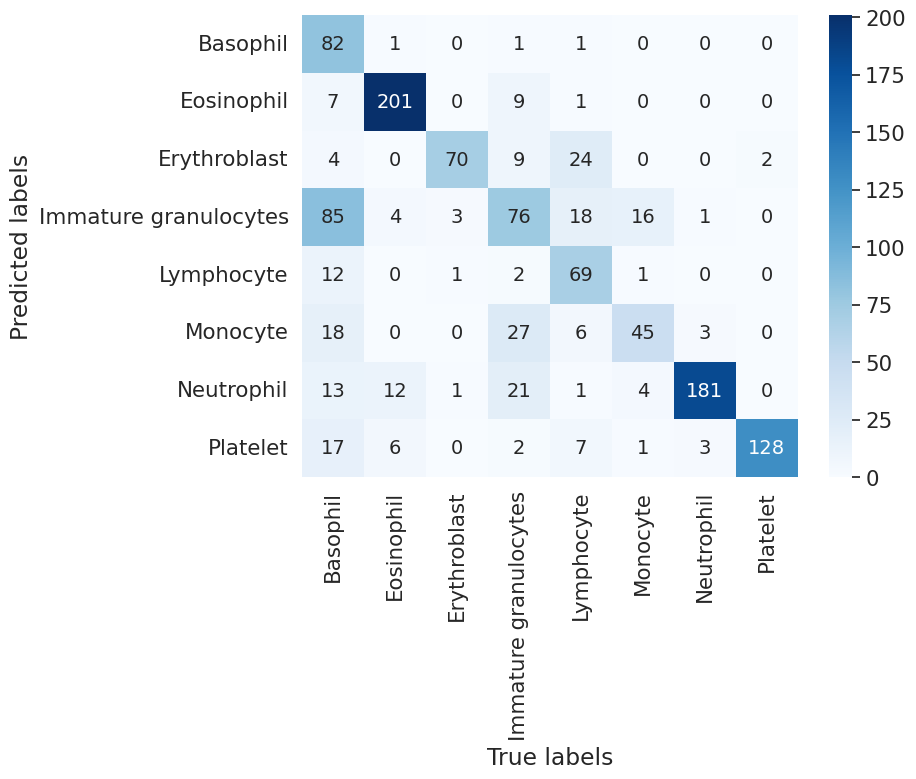

FINE TUNING ANALYSIS
Accuracy score over the validation set: 0.9114
Precision score over the validation set: 0.9208
Recall score over the validation set: 0.9114
F1 score over the validation set: 0.9126


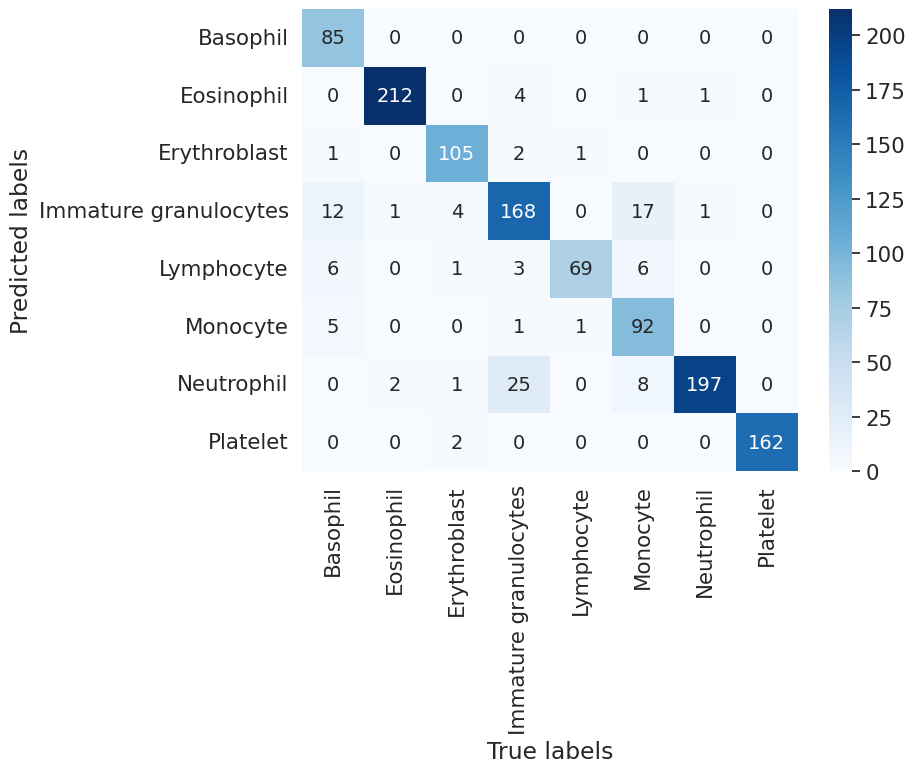

In [30]:
# Predict class probabilities and get predicted classes
print("TRANSFER LEARNING ANALYSIS")
model = tfk.models.load_model(folder_name+'/weightsTL.keras')

val_predictions = model.predict(X_val, verbose=0)
val_predictions = np.argmax(val_predictions, axis=-1)

# Extract ground truth classes
val_gt = np.argmax(y_val, axis=-1)

# Calculate and display validation set accuracy
val_accuracy = accuracy_score(val_gt, val_predictions)
print(f'Accuracy score over the validation set: {round(val_accuracy, 4)}')

# Calculate and display validation set precision
val_precision = precision_score(val_gt, val_predictions, average='weighted')
print(f'Precision score over the validation set: {round(val_precision, 4)}')

# Calculate and display validation set recall
val_recall = recall_score(val_gt, val_predictions, average='weighted')
print(f'Recall score over the validation set: {round(val_recall, 4)}')

# Calculate and display validation set F1 score
val_f1 = f1_score(val_gt, val_predictions, average='weighted')
print(f'F1 score over the validation set: {round(val_f1, 4)}')

# Compute the confusion matrix
cm = confusion_matrix(val_gt, val_predictions)

# Create labels combining confusion matrix values
labels = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Plot the confusion matrix with class labels
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=labels, fmt='', xticklabels=unique_labels, yticklabels=unique_labels, cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

print("FINE TUNING ANALYSIS")
model = tfk.models.load_model(folder_name+'/weights.keras')
val_predictions = model.predict(X_val, verbose=0)
val_predictions = np.argmax(val_predictions, axis=-1)

# Extract ground truth classes
val_gt = np.argmax(y_val, axis=-1)

# Calculate and display validation set accuracy
val_accuracy = accuracy_score(val_gt, val_predictions)
print(f'Accuracy score over the validation set: {round(val_accuracy, 4)}')

# Calculate and display validation set precision
val_precision = precision_score(val_gt, val_predictions, average='weighted')
print(f'Precision score over the validation set: {round(val_precision, 4)}')

# Calculate and display validation set recall
val_recall = recall_score(val_gt, val_predictions, average='weighted')
print(f'Recall score over the validation set: {round(val_recall, 4)}')

# Calculate and display validation set F1 score
val_f1 = f1_score(val_gt, val_predictions, average='weighted')
print(f'F1 score over the validation set: {round(val_f1, 4)}')

# Compute the confusion matrix
cm = confusion_matrix(val_gt, val_predictions)

# Create labels combining confusion matrix values
labels = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Plot the confusion matrix with class labels
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=labels, fmt='', xticklabels=unique_labels, yticklabels=unique_labels, cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()


In [ ]:
%%writefile model.py
import numpy as np

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl


class Model:
    def __init__(self):
        """
        Initialize the internal state of the model. Note that the __init__
        method cannot accept any arguments.

        The following is an example loading the weights of a pre-trained
        model.
        """
        self.neural_network = tfk.models.load_model('ResNet_Good_aug/weights.keras')

    def predict(self, X):
        """
        Predict the labels corresponding to the input X. Note that X is a numpy
        array of shape (n_samples, 96, 96, 3) and the output should be a numpy
        array of shape (n_samples,). Therefore, outputs must no be one-hot
        encoded.

        The following is an example of a prediction from the pre-trained model
        loaded in the __init__ method.
        """
        preds = self.neural_network.predict(X)
        if len(preds.shape) == 2:
            preds = np.argmax(preds, axis=1)
        return preds

In [ ]:
from datetime import datetime
filename = f'submission_{datetime.now().strftime("%y%m%d_%H%M%S")}.zip'

# Add files to the zip command if needed
!zip {filename} model.py ResNet_Good_aug/weights.keras

from google.colab import files
files.download(filename)